BÁO CÁO TÌM HIỂU THƯ VIỆN DOCTR (DOCUMENT TEXT RECOGNITION)

Giới thiệu chung
docTR (Document Text Recognition) là thư viện mã nguồn mở do Mindee phát triển, được xây dựng trên nền PyTorch và TensorFlow, dùng cho bài toán OCR (Optical Character Recognition) – trích xuất văn bản từ ảnh hoặc tài liệu PDF bằng kỹ thuật Deep Learning.
docTR cung cấp pipeline end-to-end gồm hai giai đoạn chính:
(1) Text Detection – Xác định vùng chứa văn bản trong ảnh.
(2) Text Recognition – Nhận dạng nội dung chữ trong từng vùng được phát hiện.
Mục tiêu của docTR là thay thế các công cụ OCR truyền thống như Tesseract bằng giải pháp học sâu có độ chính xác cao và linh hoạt hơn.

Kiến trúc tổng quan
Quy trình xử lý tài liệu trong docTR:
Ảnh tài liệu → Phát hiện văn bản → Cắt vùng chữ → Nhận dạng ký tự → Xuất kết quả (text, JSON hoặc ảnh chú thích).

Các mô hình được hỗ trợ:

Detection: DBNet, LinkNet, CTPN.

Recognition: CRNN, SAR, VisionTransformer.
Mỗi mô hình đều có phiên bản pretrained để sử dụng ngay.

Cách cài đặt và sử dụng (Google Colab)
!pip install python-doctr torch torchvision matplotlib pillow
from doctr.models import ocr_predictor
from doctr.io import DocumentFile
model = ocr_predictor(pretrained=True)
doc = DocumentFile.from_images("sample.jpg")
result = model(doc)
print(result.render())

Hiển thị kết quả:
import matplotlib.pyplot as plt
fig = result.show(doc)
plt.show()

Đánh giá thực nghiệm
Ưu điểm:

Nhận dạng chính xác cao với tiếng Anh và ký tự Latin.

Giữ được bố cục và vị trí văn bản trong ảnh.

Dễ sử dụng, hỗ trợ GPU, có thể mở rộng.
Hạn chế:

Chưa tối ưu cho tiếng Việt, đặc biệt chữ có dấu hoặc font viết tay.

Dữ liệu huấn luyện chủ yếu là tiếng Anh.

Không có sẵn model tiếng Việt.
Ví dụ:
“Cộng hòa xã hội chủ nghĩa Việt Nam” → “Cong hoa xa hoi chu nghia Viet Nam”
“Giấy chứng minh nhân dân” → “Giay chung minh nhan dan”
=> Mất dấu do mô hình recognition chưa học đặc trưng tiếng Việt.

Hướng phát triển và tinh chỉnh cho tiếng Việt
Mục tiêu: Cải thiện độ chính xác nhận dạng tiếng Việt (đọc đúng dấu, font chữ Việt).

Hướng đi đề xuất:
(1) Fine-tune mô hình recognition

Giữ nguyên detection (DBNet pretrained).

Fine-tune recognition (CRNN, SAR, Transformer) trên dataset tiếng Việt có nhãn text.

Dataset có thể dùng: Vietnamese Scene Text (UIT-ViText) hoặc tự tạo từ hóa đơn, giấy tờ.

Chuẩn hóa annotation theo format JSON của docTR.

(2) Mở rộng bảng ký tự

Cập nhật charset trong recognition để bao gồm đầy đủ dấu tiếng Việt: ă, â, ê, ô, ơ, ư, đ, á, à, ả, ã, ạ,...

Giúp mô hình học mapping chính xác giữa hình dạng và ký tự có dấu.

(3) Data augmentation

Tăng cường dữ liệu bằng xoay, làm mờ, thay đổi độ sáng, thêm nhiễu.

Giúp mô hình ổn định hơn khi gặp ảnh thực tế.

(4) Xử lý sau (post-processing)

Dùng từ điển hoặc mô hình ngôn ngữ tiếng Việt để hiệu chỉnh lỗi chính tả, ví dụ “Cong hoa” → “Cộng hòa”.

Kết luận
docTR là công cụ mạnh mẽ, hiện đại cho OCR bằng học sâu, dễ sử dụng và triển khai.
Tuy nhiên, để ứng dụng hiệu quả cho tiếng Việt cần:

Fine-tune mô hình recognition,

Cập nhật bảng ký tự có dấu,

Dùng dataset tiếng Việt phù hợp.
Tinh chỉnh này khả thi nhờ kiến trúc mô-đun của docTR và có thể giúp tăng độ chính xác OCR trong các ứng dụng như số hóa hồ sơ, nhận dạng giấy tờ, trích xuất thông tin hành chính, hóa đơn điện tử.

In [ ]:
!pip install python-doctr torch torchvision matplotlib pillow


In [ ]:
from doctr.models import ocr_predictor
from doctr.io import DocumentFile

# tạo model OCR có sẵn (end-to-end)
model = ocr_predictor(pretrained=True)

In [34]:
!pip install python-doctr torch torchvision opencv-python-headless matplotlib

import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from doctr.io import DocumentFile
from doctr.models import ocr_predictor
import torch

print("Packages installed and imported successfully!")

Packages installed and imported successfully!


FINE-TUNE MÔ HÌNH DOCTR CHO TIẾNG VIỆT

Mục tiêu
Thư viện docTR (Document Text Recognition) có sẵn các mô hình OCR pretrained cho tiếng Anh và các ký tự Latin. Tuy nhiên, các mô hình này chưa đọc tốt tiếng Việt có dấu. Mục tiêu của việc fine-tune là tinh chỉnh phần Text Recognition để mô hình nhận dạng đúng các ký tự tiếng Việt, trong khi vẫn giữ nguyên phần phát hiện chữ (Text Detection).

Cấu trúc mô hình docTR
Hệ thống OCR trong docTR gồm hai phần chính:
(1) Text Detection (ví dụ DBNet, LinkNet) dùng để phát hiện vùng chứa chữ trong ảnh.
(2) Text Recognition (ví dụ CRNN, SAR, VisionTransformer) dùng để nhận dạng nội dung chữ trong từng vùng đó.
Trong giai đoạn fine-tune, chỉ cần huấn luyện lại phần Recognition, vì phần Detection không phụ thuộc ngôn ngữ.

Dữ liệu huấn luyện
Đầu vào cần là các ảnh chữ hoặc dòng văn bản, cùng với nhãn text tương ứng.
Cấu trúc thư mục dữ liệu như sau:
data/
├── train/
│ ├── img1.jpg
│ ├── img2.jpg
│ └── labels.json
└── val/
├── img3.jpg
├── img4.jpg
└── labels.json

File labels.json lưu thông tin cặp ảnh - text, ví dụ:
{"annotations": [{"image": "img1.jpg", "text": "Cộng hòa xã hội chủ nghĩa Việt Nam"}, {"image": "img2.jpg", "text": "Giấy chứng minh nhân dân"}]}

Bảng ký tự tiếng Việt
docTR mặc định chỉ có bảng ký tự Latin. Để huấn luyện cho tiếng Việt, cần mở rộng charset để bao gồm các ký tự có dấu:
0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZàáạảãăằắẳẵặâầấẩẫậèéẹẻẽêềếểễệìíịỉĩòóọỏõôồốổỗộơờớởỡợùúụủũưừứửữựỳýỵỷỹđ và khoảng trắng.

Quy trình fine-tune
Bước 1: Nạp dataset tiếng Việt đã chuẩn bị, định nghĩa hàm Resize để chuẩn hóa ảnh (ví dụ 32x128 pixel).
Bước 2: Tạo mô hình recognition mới, ví dụ crnn_vgg16_bn, với vocab=charset tiếng Việt.
Bước 3: Cấu hình Trainer trong docTR, chỉ định optimizer (Adam), learning rate (1e-4), số epoch (ví dụ 50), hàm loss (CTC) và metric (TextMatch).
Bước 4: Tiến hành huấn luyện bằng trainer.fit(). Sau khi hoàn tất, lưu trọng số model (ví dụ crnn_vi.pth).
Bước 5: Load lại mô hình đã huấn luyện và kiểm tra bằng ảnh thử nghiệm.

Lưu ý khi huấn luyện

Nếu dữ liệu nhỏ, nên freeze backbone CNN và chỉ train phần LSTM + Linear.

Dùng data augmentation (xoay ±5°, thay nền, thêm nhiễu) để tăng khả năng tổng quát.

Có thể tăng kích thước ảnh (W=256 hoặc 512) nếu text dài.

Giảm learning rate hoặc dùng dropout khi bị overfit.

Nếu cần mô hình mạnh hơn, có thể thay CRNN bằng SAR hoặc Transformer.

Đánh giá và ứng dụng
Sau khi fine-tune, mô hình có thể đọc chính xác các ký tự tiếng Việt có dấu và giữ nguyên bố cục trong văn bản. Hệ thống có thể được áp dụng cho các bài toán như số hóa hồ sơ, nhận dạng hóa đơn, trích xuất thông tin hành chính, hoặc tài liệu tiếng Việt nói chung.

Kết luận
Fine-tune docTR cho tiếng Việt giúp cải thiện đáng kể độ chính xác của OCR so với mô hình mặc định. Việc mở rộng bảng ký tự và huấn luyện lại Recognition model trên dữ liệu tiếng Việt là hướng đi thiết thực, giúp thư viện docTR thích ứng với ngôn ngữ có dấu phức tạp như tiếng Việt.

Dưới đây là phần detection

Upload an image for text detection:


Saving 553655723_1123929623268638_7620765683896878252_n.jpg to 553655723_1123929623268638_7620765683896878252_n (27).jpg
Processing: 553655723_1123929623268638_7620765683896878252_n (27).jpg
Loading model...
Model loaded successfully!
Loading image...
Performing text detection...


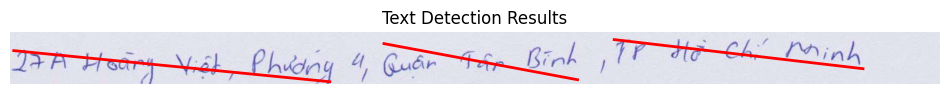

Detection completed! Found 3 text lines

=== DETECTION DETAILS ===
Total blocks: 1
Total lines: 3
Total words: 12

First 5 detected regions:
  Block 0, Line 0: BBox [7, 37, 637, 99]
  Block 0, Line 1: BBox [745, 23, 1131, 95]
  Block 0, Line 2: BBox [1204, 15, 1700, 73]


In [37]:
from doctr.io import DocumentFile
from doctr.models import ocr_predictor
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files

# Upload image
print("Upload an image for text detection:")
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
print(f"Processing: {image_path}")

# Load model and perform detection
print("Loading model...")
model = ocr_predictor(pretrained=True)
print("Model loaded successfully!")

print("Loading image...")
doc = DocumentFile.from_images(image_path)
print("Performing text detection...")
result = model(doc)

# Visualize results
import cv2
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(image)
ax.set_title('Text Detection Results')
ax.axis('off')

# Draw detections - FIXED VERSION
if hasattr(result, 'pages') and len(result.pages) > 0:
    page = result.pages[0]
    line_count = 0

    for block in page.blocks:
        for line in block.lines:
            # FIX: Properly access geometry coordinates
            polygon = line.geometry
            # Convert to numpy array and extract coordinates
            poly_array = np.array(polygon)
            x_coords = poly_array[:, 0] * image.shape[1]
            y_coords = poly_array[:, 1] * image.shape[0]

            points = np.column_stack([x_coords, y_coords]).astype(int)

            # Draw polygon
            ax.plot(points[:, 0], points[:, 1], 'r-', linewidth=2)
            ax.fill(points[:, 0], points[:, 1], 'red', alpha=0.2)
            line_count += 1

plt.show()
print(f"Detection completed! Found {line_count} text lines")

# Print detailed information about detections
print("\n=== DETECTION DETAILS ===")
if hasattr(result, 'pages') and len(result.pages) > 0:
    page = result.pages[0]
    total_blocks = len(page.blocks)
    total_lines = sum(len(block.lines) for block in page.blocks)
    total_words = sum(len(line.words) for block in page.blocks for line in block.lines)

    print(f"Total blocks: {total_blocks}")
    print(f"Total lines: {total_lines}")
    print(f"Total words: {total_words}")

    # Show first few detections with coordinates
    print("\nFirst 5 detected regions:")
    for block_idx, block in enumerate(page.blocks[:2]):  # Show first 2 blocks
        for line_idx, line in enumerate(block.lines[:3]):  # Show first 3 lines per block
            polygon = np.array(line.geometry)
            bbox = [
                polygon[:, 0].min() * image.shape[1],
                polygon[:, 1].min() * image.shape[0],
                polygon[:, 0].max() * image.shape[1],
                polygon[:, 1].max() * image.shape[0]
            ]
            print(f"  Block {block_idx}, Line {line_idx}: BBox {[int(x) for x in bbox]}")

Phần cho kết quả pretrain

In [38]:
# Simple version - Focus on recognition results
from doctr.io import DocumentFile
from doctr.models import ocr_predictor
from google.colab import files

# Upload and process
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# Load model (đã bao gồm cả detection và recognition)
model = ocr_predictor(pretrained=True)
doc = DocumentFile.from_images(image_path)
result = model(doc)

# Extract and display all recognized text
print("=== RECOGNIZED TEXT ===")
if hasattr(result, 'pages') and len(result.pages) > 0:
    page = result.pages[0]

    full_text = ""
    for block_idx, block in enumerate(page.blocks):
        block_text = ""
        for line_idx, line in enumerate(block.lines):
            line_text = " ".join([word.value for word in line.words])
            block_text += line_text + " "

        print(f"Block {block_idx}: {block_text.strip()}")
        full_text += block_text.strip() + "\n"

    print(f"\n=== FULL TEXT ===")
    print(full_text)

    # Save to file
    with open('recognized_text.txt', 'w', encoding='utf-8') as f:
        f.write(full_text)
    print("✅ Text saved to 'recognized_text.txt'")

Saving 553655723_1123929623268638_7620765683896878252_n.jpg to 553655723_1123929623268638_7620765683896878252_n (28).jpg
=== RECOGNIZED TEXT ===
Block 0: 27 A Hoany Viet Phudng Quan Tar Bink TP do Chi minh

=== FULL TEXT ===
27 A Hoany Viet Phudng Quan Tar Bink TP do Chi minh

✅ Text saved to 'recognized_text.txt'


Nhận xét: này nó chỉ phục vụ tiếng anh, ko có tham số lang như easyOCR hay jj đó, tóm lại là finetune Tiếng Việt thì khả năng cũng đọc đc cả tiếng anh